In [1]:
# install packages if imports dont work

import numpy as np
import pandas as pd
import seaborn as sns
import os
from numpy.polynomial import polynomial as P
from matplotlib import pyplot as plt

#### Information about the data set:

Title: Inferring strategies from observations in long iterated prisoner’s dilemma experiments

Link: https://datadryad.org/stash/dataset/doi:10.5061%2Fdryad.37pvmcvmk

Game: Repeated PD randomly; matched partners

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | (3, 3)     | (0, 4) |
| **D**           | (4, 0)     | (1, 1) |

In [2]:
# Setting working directory

print(f'Before={os.getcwd()}') 
#os.chdir('C:\\Users\\1412r\\sciebo\\GuiltAndResponsibility') # Set wd to \sciebo\GuiltAndResponsibility
#print(f'After={os.getcwd()}')

Before=C:\Users\1412r\sciebo\GuiltAndResponsibility\Codes
After=C:\Users\1412r\sciebo\GuiltAndResponsibility


In [3]:
# Get csv data

#print(os.getcwd())
path = 'Data/PD_Data1/rand.csv'
df = pd.read_csv(path, header=0, delimiter=';')

#df.head()

In [4]:
# Housekeeping

drop_cols = ['time_php', 'time_js', 'treatment', 'context', 'prev', 'prev_player',  'prev_opp', 'session']
df.drop(columns=drop_cols, inplace=True)

In [5]:
# Checking how the dataset looks

print(f'The shape of df is {df.shape}\n')
print(df.groupby(['player']).count())
print(df.info())
df.describe()

The shape of df is (9600, 6)

                round  action_player  opponent  action_opponent  payoff
player                                                                 
s11n9usuario1     100            100       100              100     100
s11n9usuario10    100            100       100              100     100
s11n9usuario2     100            100       100              100     100
s11n9usuario3     100            100       100              100     100
s11n9usuario4     100            100       100              100     100
...               ...            ...       ...              ...     ...
s7m22usuario5     100            100       100              100     100
s7m22usuario6     100            100       100              100     100
s7m22usuario7     100            100       100              100     100
s7m22usuario8     100            100       100              100     100
s7m22usuario9     100            100       100              100     100

[96 rows x 5 columns]
<class 'pan

,round,payoff
count,9600.000000,9600.000000
mean,50.500000,1.570417
std,28.867574,1.421502
min,1.000000,0.000000
25%,25.750000,1.000000
50%,50.500000,1.000000
75%,75.250000,3.000000
max,100.000000,4.000000


1) 96 subjects with mostly 100 trials each
2) action_player is the dependent variable, payoff is one of the dependent variable
3) No NaN values

4) Mean payoff is 1.57, closest to 1 in the payoff matrix, which is obtained by the combination of actions (D, D)

In [6]:
# Add column for the partner's payoff

df['payoff_opponent'] = df['payoff'] # Payoffs are same when both take the same action
df['payoff_opponent'].loc[(df['action_player']=='C') & (df['action_opponent']=='D')] = 4
df['payoff_opponent'].loc[(df['action_player']=='D') & (df['action_opponent']=='C')] = 0

C:\Users\1412r\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
df.head() 
#df.tail() # see last 5 rows

,round,player,action_player,opponent,action_opponent,payoff,payoff_opponent
0,1,s11n9usuario1,C,s11n9usuario10,C,3,3
1,2,s11n9usuario1,C,s11n9usuario10,D,0,4
2,3,s11n9usuario1,C,s11n9usuario7,C,3,3
3,4,s11n9usuario1,C,s11n9usuario8,D,0,4
4,5,s11n9usuario1,C,s11n9usuario7,C,3,3


The number of rows with equal payoffs is 5744


<AxesSubplot:>

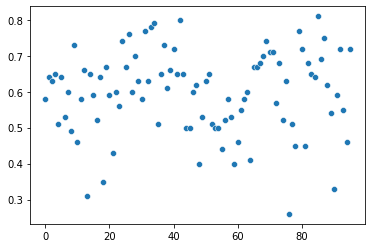

In [8]:
# Checking fraction of rows with equal payoffs

number_of_participants = len(df['player'].unique())
x = (df[df['payoff']==df['payoff_opponent']]).shape[0]
print(f'The number of rows with equal payoffs is {x}')

frac = (df[df['payoff']==df['payoff_opponent']].value_counts(subset=['player'])/df.value_counts(subset=['player']))
sns.scatterplot(y=frac, x=range(number_of_participants))


Again, atleast 1/3 of rows have equal payoff for both self and other for every participant (???)

# Zero level Player

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | $$(3, 3)$$     | $$(4\alpha_1, 4)$$ |
| **D**           | $$(4(1-\beta_1), 0)$$     | $$(1, 1)$$ |

#### (Change the table below into a graph, its better for visualization)
Best response of the player (format: (when opponent plays C, when opponent plays D)):

|  | $$\alpha < \frac{1}{4}$$      | $$\alpha > \frac{1}{4}$$   |
| ------          | ----- | ---- |
| **$$\beta < \frac{1}{4}$$**           | (D, D)     | (D, C) |
| **$$\beta > \frac{1}{4}$$**           | (C, D)     | (C, C) |

For 0 level player, belief about opponent's parameters: alpha = beta = 0. Thus, the opponent will play D. So the best response will be to play D if $\alpha$ is less than 1/4 and C otherwise. **(Checkpoint1: Assumption is that only beliefs about alpha and beta vary over levels not the strategy)**

In [9]:
# Grid parameters

steps = 11 ##### Input number of steps here
N = df.shape[0]

alpha_range = np.linspace(0, 1, steps, endpoint=True)
beta_range  = np.linspace(0, 1, steps, endpoint=True)
col = []

for alpha in alpha_range: 
    for beta in beta_range: 
        name = str(alpha), str(beta)
        col  = col + [name]

In [10]:
# Create empty dataframes
action = pd.DataFrame(index=df.index, columns=col)    # utility matrix
error = pd.DataFrame(index=df.index, columns=col)     # error matrix

In [11]:
# Utility Grid: D for alpha < 0.25 and C for alpha > 0.25 (no equality in 11 steps' case)

for i in range(len(col)):
    alpha = float(col[i][0]) # convert alpha (from column name) from string to float
    if alpha < 0.25:
        action.iloc[:, i] = 'D'
    if alpha > 0.25:
        action.iloc[:, i] = 'C'
        
#action.head()

For now not dropping rows for actions with equal payoffs  **(Checkpoint2)**

In [12]:
# Calculating error matrix

for x in col:
    error[x] = action[x]==df['action_player'] # this is done differently wrt previous codes because here we compare string vs string (eg C vs C), while before we compared numbers and subtraction is supported only for numeric values
    
error = 1 - error # Converting to ones and zeros from trues and falses
error['player'] = df['player'] # Adding player column for easier future calculations
#error.head()

In [13]:
# Calculate average error for each participant

data = []

for i in df['player'].unique():
    sum_of_error = (error[error['player']==i].iloc[:,:-1]).sum() # summing over error rows where player == i and taking every column except the last (which is the name column) using iloc
    number_of_trials = (df['player']==i).sum()
    data = data + [sum_of_error/number_of_trials]
    
avg_error = pd.DataFrame(data=data)
#avg_error.head()

There was no need to square errors in this case because errors were not negative (only zeroes and ones)

#### Finding minimum error

Since in this case all error before $\alpha = 0.25$ are same and all after are same. Effectively, there are only two useful buckets of alpha. So, subsequently using only two buckets instead of 11 to plot

In [14]:
# Calculating fraction of players in the lower alpha bracket

frac = sum(avg_error.iloc[:, 0]<=0.5)/number_of_participants # sum of rows of first column of avg_error which are less than 0.5 divided by no of participants
frac # taking less than 0.5 because the other error is compliment of this (check avg_error df)

0.78125

So 78% participants lie in the smaller alpha bracket

Text(0.5, 0, 'Error')

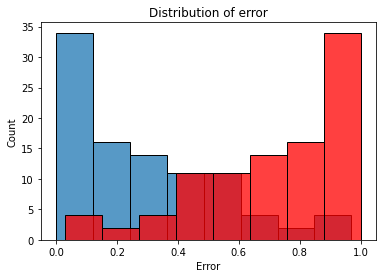

In [15]:
fig, ax = plt.subplots()

pt1 = sns.histplot(x=avg_error.iloc[:, 0], ax=ax) # when alpha is in the lower bracket
pt2 = sns.histplot(x=avg_error.iloc[:, -1], ax=ax, color='red') # in the higher bracket
plt.title('Distribution of error')
plt.xlabel('Error')

# Level 1 PLayer

Level 1 players assume that everyone has the same parameter values, ie $\alpha_1=\alpha_2=\alpha$ and $\beta_1=\beta_2=\beta$

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | $(3, 3)$     | $$(4\alpha, 4(1-\beta))$$ |
| **D**           | $$(4(1-\beta), 4\alpha)$$     | $$(1, 1)$$ |

If player 2 plays C, best response of player 1 is

$$
    \text{best response} = 
    \begin{cases}
        C & \mbox{if } \beta > 0.25\\
        D & \mbox{if } \beta < 0.25\\
        \{C, D\} & \mbox{if } \beta = 0.25
    \end{cases}
$$

And if player 2 plays D, best response of player 1 is

$$
    \text{best response} = 
    \begin{cases}
        C & \mbox{if } \alpha > 0.25\\
        D & \mbox{if } \alpha < 0.25\\
        \{C, D\} & \mbox{if } \alpha = 0.25
    \end{cases}
$$

Broadly there will be four types of players, low-$\alpha$ low-$\beta$ type, low-$\alpha$ high-$\beta$ type, high-$\alpha$ low-$\beta$ and high-$\alpha$ high-$\beta$ type. And each will have thier own equilibrium strategy.

1) For the low-low type, playing D is the dominant strategyand for the high-high type, dominant strategy is C
2) For low-high and high-low types there are two pure strategy Nash equilibria and one mixed strategy.

Assume that the players choose actions such that the equilibrium with higher payoff is achieved. **(Checkpoint3)**

Now, for low-high type, the equilibria are (C, C) and (D, D), first gives the player a payoff of 3 and the second gives 1. So low-high type will play C. For high-low type, the equilibria are (C, D) and (D, C) which give respective payoffs, $4\alpha$ and $4(1-\beta)$. Thus, if $\alpha+\beta>1$ player will play C and the opponent will play D and vice versa in the other case.

### (Add this alpha-beta strategy graph using latex later)

In [24]:
# Create empty dataframes
action1 = pd.DataFrame(index=df.index, columns=col) # utility matrix
error1 = pd.DataFrame(index=df.index, columns=col)     # error matrix

In [25]:
# Utility Grid: C for beta > 0.25 and C for beta < 0.25 except when alpha > 0.75 (no equality in 11 steps' case)

for i in range(len(col)):
    beta = float(col[i][1]) # convert beta (from column name) from string to float
    if beta > 0.25:
        action1.iloc[:, i] = 'C'
    if beta < 0.25:
        alpha = float(col[i][0])
        if alpha > 0.75:
            action1.iloc[:, i] = 'C'
        if alpha < 0.75:
            action1.iloc[:, i] = 'D'
        
#action1.head()

,"(0.0, 0.0)","(0.0, 0.1)","(0.0, 0.2)","(0.0, 0.30000000000000004)","(0.0, 0.4)","(0.0, 0.5)","(0.0, 0.6000000000000001)","(0.0, 0.7000000000000001)","(0.0, 0.8)","(0.0, 0.9)",...,"(1.0, 0.1)","(1.0, 0.2)","(1.0, 0.30000000000000004)","(1.0, 0.4)","(1.0, 0.5)","(1.0, 0.6000000000000001)","(1.0, 0.7000000000000001)","(1.0, 0.8)","(1.0, 0.9)","(1.0, 1.0)"
0,D,D,D,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
1,D,D,D,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
2,D,D,D,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
3,D,D,D,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
4,D,D,D,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C


In [26]:
# Calculating error matrix

for x in col:
    error1[x] = action1[x]==df['action_player']
    
error1 = 1 - error1 # Converting to ones and zeros from trues and falses
error1['player'] = df['player'] # Adding player column for easier future calculations

#error1.head()

,"(0.0, 0.0)","(0.0, 0.1)","(0.0, 0.2)","(0.0, 0.30000000000000004)","(0.0, 0.4)","(0.0, 0.5)","(0.0, 0.6000000000000001)","(0.0, 0.7000000000000001)","(0.0, 0.8)","(0.0, 0.9)",...,"(1.0, 0.2)","(1.0, 0.30000000000000004)","(1.0, 0.4)","(1.0, 0.5)","(1.0, 0.6000000000000001)","(1.0, 0.7000000000000001)","(1.0, 0.8)","(1.0, 0.9)","(1.0, 1.0)",player
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,s11n9usuario1
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,s11n9usuario1
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,s11n9usuario1
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,s11n9usuario1
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,s11n9usuario1


In [27]:
# Calculate average error for each participant

data = []

for i in df['player'].unique():
    sum_of_error = (error1[error1['player']==i].iloc[:,:-1]).sum() # summing over error rows where player == i and taking every column except the last (which is the name column) using iloc
    number_of_trials = (df['player']==i).sum()
    data = data + [sum_of_error/number_of_trials]
    
avg_error1 = pd.DataFrame(data=data)

#avg_error1.head()

,"(0.0, 0.0)","(0.0, 0.1)","(0.0, 0.2)","(0.0, 0.30000000000000004)","(0.0, 0.4)","(0.0, 0.5)","(0.0, 0.6000000000000001)","(0.0, 0.7000000000000001)","(0.0, 0.8)","(0.0, 0.9)",...,"(1.0, 0.1)","(1.0, 0.2)","(1.0, 0.30000000000000004)","(1.0, 0.4)","(1.0, 0.5)","(1.0, 0.6000000000000001)","(1.0, 0.7000000000000001)","(1.0, 0.8)","(1.0, 0.9)","(1.0, 1.0)"
0,0.25,0.25,0.25,0.75,0.75,0.75,0.75,0.75,0.75,0.75,...,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
1,0.05,0.05,0.05,0.95,0.95,0.95,0.95,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95
2,0.28,0.28,0.28,0.72,0.72,0.72,0.72,0.72,0.72,0.72,...,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
3,0.31,0.31,0.31,0.69,0.69,0.69,0.69,0.69,0.69,0.69,...,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69
4,0.52,0.52,0.52,0.48,0.48,0.48,0.48,0.48,0.48,0.48,...,0.48,0.48,0.48,0.48,0.48,0.48,0.48,0.48,0.48,0.48


In [44]:
# Minimise error

min_error1 = avg_error1.idxmin(axis=1) # gives the first pair where minimum error occurs
#min_error1

('0.0', '0.30000000000000004')

Text(0.5, 1.0, 'Alpha')

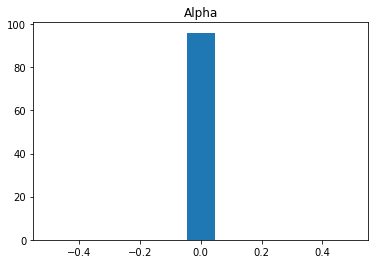

In [53]:
# Creating list of alphas for each subject
obs_alpha = []

for x in min_error1:
    obs_alpha = obs_alpha + [x[0]]
    
obs_alpha = [float(x) for x in obs_alpha]


# Plotting alpha
plt.hist(obs_alpha, bins=11)
plt.title('Alpha')

Text(0.5, 1.0, 'Beta')

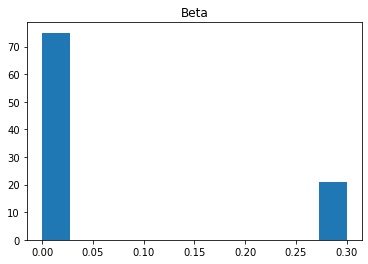

In [56]:
# Creating list of betas for each subject
obs_beta = []

for x in min_error1:
    obs_beta = obs_beta + [x[1]]
    
obs_beta = [float(x) for x in obs_beta]


# PLotting beta
plt.hist(obs_beta, bins=11)
plt.title('Beta')

In [52]:
avg_error1[min_error1[0]][0]==avg_error1.iloc[0, :]

(0.0, 0.0)                     True
(0.0, 0.1)                     True
(0.0, 0.2)                     True
(0.0, 0.30000000000000004)    False
(0.0, 0.4)                    False
                              ...  
(1.0, 0.6000000000000001)     False
(1.0, 0.7000000000000001)     False
(1.0, 0.8)                    False
(1.0, 0.9)                    False
(1.0, 1.0)                    False
Name: 0, Length: 121, dtype: bool

Plot alpha vs beta (heatmap?)